# Histology colourisation using conditional GAN

### AIM
<div style = "text-align: justify">The aim of this notebook is to <b>generate coloured image, given a grayscale image as input.</b> This notebook takes inspiration from <b>End-to-End Conditional GAN based Architectures for Image Colourisation</b> by Marc Gorriz Blanch, Marta Mrak, Alan F. Smeaton and Noel E. O'Connor.</div>

### Updates
<div style = "text-align: justify">In the version 7 of the notebook, I used the <b>base Pix2Pix GAN model</b> for image colourisation. And as stated by the authors of this paper, a fraction of the images generated were desaturated. <b>To mitigate the lack of colourfulness, this model architecture was proposed.</b></div>

### The dataset can be found [here](https://www.kaggle.com/datasets/kmader/colorectal-histology-mnist).

### Resources

<div style = "text-align: justify"><b>Most of the work was done on base Pix2Pix network</b> and additional ideas were introduced for better results. Following are the papers I referred to for understanding the different concepts and models to implement,</div>

<br>

<div style = "text-align: justify"><b>[1]</b> M. G. Blanch, M. Mrak, A. F. Smeaton and N. E. O'Connor, "End-to-End Conditional GAN-based Architectures for Image Colourisation," 2019 IEEE 21st International Workshop on Multimedia Signal Processing (MMSP), 2019, pp. 1-6, doi: 10.1109/MMSP.2019.8901712.</div>

<br>

<div style = "text-align: justify"><b>[2]</b> Isola, Phillip et al. “Image-to-Image Translation with Conditional Adversarial Networks.” 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR) (2017): 5967-5976.</div>

<br>

<div style = "text-align: justify"><b>[3]</b> T. Miyato, T. Kataoka, M. Koyama, and Y. Yoshida, “Spectral normalization for generative adversarial networks,” arXiv:1802.05957, 2018.</div>

<br>

<div style = "text-align: justify"><b>[4]</b> Wang, T. et al. “High-Resolution Image Synthesis and Semantic Manipulation with Conditional GANs.” 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition (2018): 8798-8807.</div>

<br>

<div style = "text-align: justify"><b>[5]</b> D. Ulyanov, A. Vedaldi, and V. Lempitsky, “Instance normalization: The missing ingredient for fast stylization,” arXiv:1607.08022, 2016.</div>

# Import the dataset

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

In [60]:
clr_path = "/kaggle/input/landscape-image-colorization/landscape Images/color"
gry_path = "/kaggle/input/landscape-image-colorization/landscape Images/gray"

In [105]:
clr_path = "/kaggle/input/HistTumour/01_TUMOR"
#gry_path = "/kaggle/input/HistTumour/01_TUMOR"

In [108]:
import os

clr_img_path = []
gry_img_path = []

for img_path in os.listdir(clr_path) :
    clr_img_path.append(os.path.join(clr_path, img_path))
    
for img_path in os.listdir(clr_path) :
    gry_img_path.append(os.path.join(clr_path, img_path))

In [109]:
clr_img_path.sort()
gry_img_path.sort()

In [110]:
from PIL import Image
from tensorflow.keras.utils import img_to_array

X = []
y = []

for i in range(200) :
    
    img1 = cv2.cvtColor(cv2.imread(clr_img_path[i]), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(gry_img_path[i]), cv2.IMREAD_GRAYSCALE)

    y.append(img_to_array(Image.fromarray(cv2.resize(np.asarray(img1),(128,128)))))
    X.append(img_to_array(Image.fromarray(cv2.resize(np.asarray(img2),(128,128)))))

In [111]:
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(200, 128, 128, 4)
(200, 128, 128, 3)


In [112]:
X=X[:,:,:,:3]

In [113]:
print(X.shape)
print(y.shape)

(200, 128, 128, 3)
(200, 128, 128, 3)


In [12]:
print(X.min())
print(X.max())

0.0
255.0


In [13]:
print(y.min())
print(y.max())

0.0
255.0


# Overview of the dataset & Visualizations

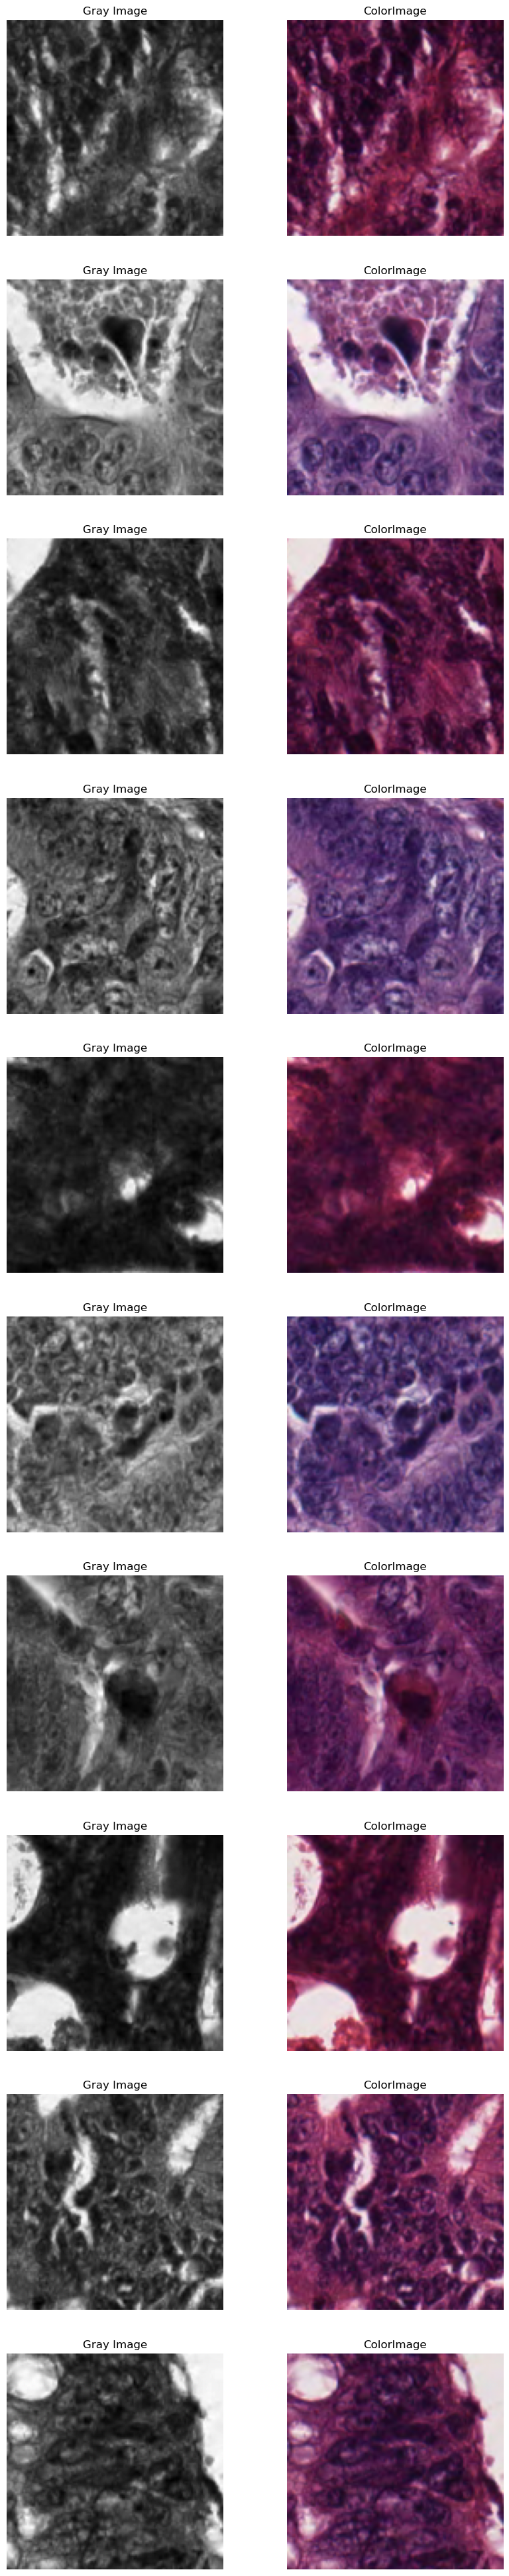

In [49]:
plt.figure(figsize = (10,50))

i = 0

while i < 20:
    
    x = np.random.randint(0,200)
    
    plt.subplot(10, 2, i+1)
    plt.imshow((X[x,:,:,:1]/255.0),cmap='gray')
    plt.axis('off')
    plt.title('Gray Image')
    
    plt.subplot(10, 2, i+2)
    plt.imshow(y[x]/ 255.0)
    plt.axis('off')
    plt.title('ColorImage')
    i += 2
    
plt.show()

In [114]:
X = (X/127.5) - 1
y = (y/127.5) - 1

In [41]:
print(f'Minimum of X : {X.min()}')
print(f'Maximum of X : {X.max()}')

Minimum of X : -1.0
Maximum of X : 1.0


In [42]:
print(f'Minimum of y : {y.min()}')
print(f'Maximum of y : {y.max()}')

Minimum of y : -1.0
Maximum of y : 1.0


# Train-test split

In [14]:
from sklearn.model_selection import train_test_split

In [115]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle = False)

In [116]:
print(X_train.shape)
print(y_train.shape)

(170, 128, 128, 3)
(170, 128, 128, 3)


In [117]:
print(X_valid.shape)
print(y_valid.shape)

(30, 128, 128, 3)
(30, 128, 128, 3)


In [40]:
!pip install tensorflow-addons

In [71]:
from tensorflow_addons.layers import SpectralNormalization
from keras.layers import BatchNormalization
from keras.layers import ZeroPadding2D
from keras.layers import Concatenate
from keras.layers import Activation
from keras.models import Model
from keras.layers import Dense
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Conv2DTranspose
from keras.initializers import RandomNormal
from tensorflow_addons.layers import InstanceNormalization

In [118]:
'''
Weigth initialization is according to [2], which uses the Gaussian
random distribution with mean of 0 and standard deviation of 0.02.
'''

init = RandomNormal(mean = 0.0, stddev = 0.02)

# PatchGAN (Discriminator)
<div style = "text-align: justify">The PatchGAN discriminator is made up of down sampling blocks <b>d_block(...)</b> where at each step the size of the image is halved and depth is doubled. It comprises of <b>Conv-BatchNorm-LeakyReLU layers</b> with added Spectral normalization <b>[3]</b> and instance normalization <b>[5]</b>. <b>3 such patchGAN models will be used as discriminators </b> and they will be fed images of different resolutions <b>[4].</b></div>

In [119]:
def d_block (x_input, filters, strides, padding, batch_norm, inst_norm) :
    
    x = Conv2D(filters, (4, 4),
               strides=strides,
               padding=padding,
               use_bias= False,
               kernel_initializer = init)(x_input)
    
    '''
    SpectralNormalization is wrapped around convolution layer.
    Also, Instance  and  Batch Normalization layers are added.
    '''
    
    if batch_norm == True :
        x = BatchNormalization   ()(x)
    if inst_norm  == True :
        x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)
    return x


def u_block (x, skip, filters, strides, padding, batch_norm, inst_norm) :
    
    x = Conv2DTranspose(filters, (4, 4),
                        strides=strides,
                        padding=padding,
                        use_bias= False,
                        kernel_initializer = init)(x)
    
    '''
    All the 3 normalizations applied here as well.
    '''
    
    if batch_norm == True :
        x = BatchNormalization   ()(x)
    if inst_norm  == True :
        x = InstanceNormalization()(x)
    x = ReLU()(x)
    conc_x = Concatenate()([x , skip])
    
    return conc_x

In [120]:
def PatchGAN (image_shape) :
    
    genI = Input(shape =  image_shape)
    tarI = Input(shape =  image_shape)
    conc = Concatenate()([genI, tarI])
    
    c064 = d_block(conc, 2**6, 2, 'same', False, False)
    c128 = d_block(c064, 2**7, 2, 'same', False, True )
    c256 = d_block(c128, 2**8, 2, 'same', True , False)
    
    temp = ZeroPadding2D()(c256)
    
    c512 = d_block(temp, 2**9, 1,'valid', True , False)
    
    temp = ZeroPadding2D()(c512)
    
    c001 = Conv2D(2**0, (4,4), strides=1, padding = 'valid', activation = 'sigmoid', kernel_initializer=init)(temp)
    
    model = Model(inputs = [genI, tarI], outputs = c001)
    return model

In [121]:
d_model = PatchGAN((128,128,3,))
d_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_32 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_48 (Concatenate)   (None, 128, 128, 6)  0           ['input_31[0][0]',               
                                                                  'input_32[0][0]']        

# Modified U-net (Generator)
<div style = "text-align: justify">The modified U-net is made up of <b>d_block(...) and u_block(...)</b> for encoding and decoding, respectively. The basic structure of encoding path is <b>Conv-BatchNorm-LeakyReLU (slope = 0.2) layers</b> and that of decoding path is <b>TransposeConv-BatchNorm-ReLU layers</b>. In both cases Spectral Normalization <b>[3]</b> was applied. The Instance Normalization layer <b>[5]</b> was applied for last decoding layer <b>(u064)</b>.</div>

In [95]:
def mod_Unet () :
    
    srcI = Input(shape = (128,128,3,))
    
    # Contracting path
    
    c064 = d_block(srcI, 2**6, 2, 'same', False, False) # _______________________.
    c128 = d_block(c064, 2**7, 2, 'same', True , False) # ____________________.  .
    c256 = d_block(c128, 2**8, 2, 'same', True , False) # _________________.  .  .
    c512 = d_block(c256, 2**9, 2, 'same', True , False) # ______________.  .  .  .
    d512 = d_block(c512, 2**9, 2, 'same', True , False)
    print(d512.shape)# ___________.  .  .  .  .
    e512 = d_block(d512, 2**9, 2, 'same', True , False) # ________.  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    # Bottleneck layer                                            .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    f512 = d_block(e512, 2**9, 2, 'same', True , False) #         .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    # Expanding  path                                             .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    u512 = u_block(f512, e512, 2**9, 2, 'same', True, False)# ____.  .  .  .  .  .
    print(u512.shape)
    u512 = u_block(u512, d512, 2**9, 2, 'same', True, False)# _______.  .  .  .  .
    u512 = u_block(u512, c512, 2**9, 2, 'same', True, False)# __________.  .  .  .
    u256 = u_block(u512, c256, 2**8, 2, 'same', True, False)# _____________.  .  .
    u128 = u_block(u256, c128, 2**7, 2, 'same', True, False)# ________________.  .
    u064 = u_block(u128, c064, 2**6, 2, 'same', False, True)# ___________________.
    
    genI = Conv2DTranspose(3, (4,4), strides = 2, padding = 'same', activation = 'tanh', kernel_initializer = init)(u064)
    
    model = Model(inputs = srcI, outputs = genI)
    return model

In [122]:
g_model = mod_Unet()
g_model.summary()

(None, 4, 4, 512)
(None, 2, 2, 1024)
Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_107 (Conv2D)            (None, 64, 64, 64)   3072        ['input_33[0][0]']               
                                                                                                  
 leaky_re_lu_94 (LeakyReLU)     (None, 64, 64, 64)   0           ['conv2d_107[0][0]']             
                                                                                                  
 conv2d_108 (Conv2D)            (None, 32, 32, 128)  1

# Make tf.datasets

In [123]:
'''
The information for batch-size appropriate for BW->COLOR transformation
was mentioned as 4 in [1](code source). The optimizer used is Adam with
learningRate of 0.0002, beta1 = 0.5 and beta2 = 0.999 according to [2].
'''

LAMBDA = 100
BATCH_SIZE = 16
BUFFER_SIZE  = 400

In [124]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [125]:
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE)

# Load models

In [126]:
gen0 = mod_Unet()

'''
Using the idea of multi-scale discriminator from [4]. We  use three
discriminators downsampling the input volume by a factor of 2 and 4.
'''

dis0 = PatchGAN((128,128,3,)) # (W//1) x (H//1)
dis1 = PatchGAN((64, 64, 3,)) # (W//2) x (H//2)
dis2 = PatchGAN((32, 32, 3,)) # (W//4) x (H//4)

(None, 4, 4, 512)
(None, 2, 2, 1024)


In [127]:
bin_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

In [128]:
def gen_loss (dis_gen_output, target_image, gen_output) :
    
    ad_loss = bin_entropy(tf.ones_like (dis_gen_output) ,  dis_gen_output)
    l1_loss = tf.reduce_mean(tf.abs(tf.subtract(target_image,gen_output)))
    
    '''
    Total loss = adversarial +  (LAMBDA*L1)
    '''
    total_loss = ad_loss + (LAMBDA*l1_loss)
    
    return total_loss, ad_loss, l1_loss

In [129]:
def dis_loss (dis_gen_output, dis_tar_output) :
    
    gen_loss = bin_entropy(tf.zeros_like(dis_gen_output), dis_gen_output)
    tar_loss = bin_entropy(tf.ones_like (dis_tar_output), dis_tar_output)
    
    total_dis_loss = gen_loss + tar_loss
    return total_dis_loss

# Custom Training
<div style = "text-align: justify">First we are going to make the appropriate tensorflow datsets, then we declare the optimizer and checkpoint. Then we implement the training function, where we use <b>Gradient Tape</b> to retrieve the gradients of trackable objects (weights here) with repect to loss function. </div>

### Images of different resolutions

In [130]:
img  = cv2.imread('/kaggle/input/HistTumour/01_TUMOR/10A26_CRC-Prim-HE-07_025.tif_Row_1801_Col_301.tif')
img  = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (128,128))
a128 = img_to_array(Image.fromarray(img))

a128/= 255.0

a064 = cv2.resize(a128, (64,64))
a032 = cv2.resize(a064, (32,32))

(-0.5, 31.5, 31.5, -0.5)

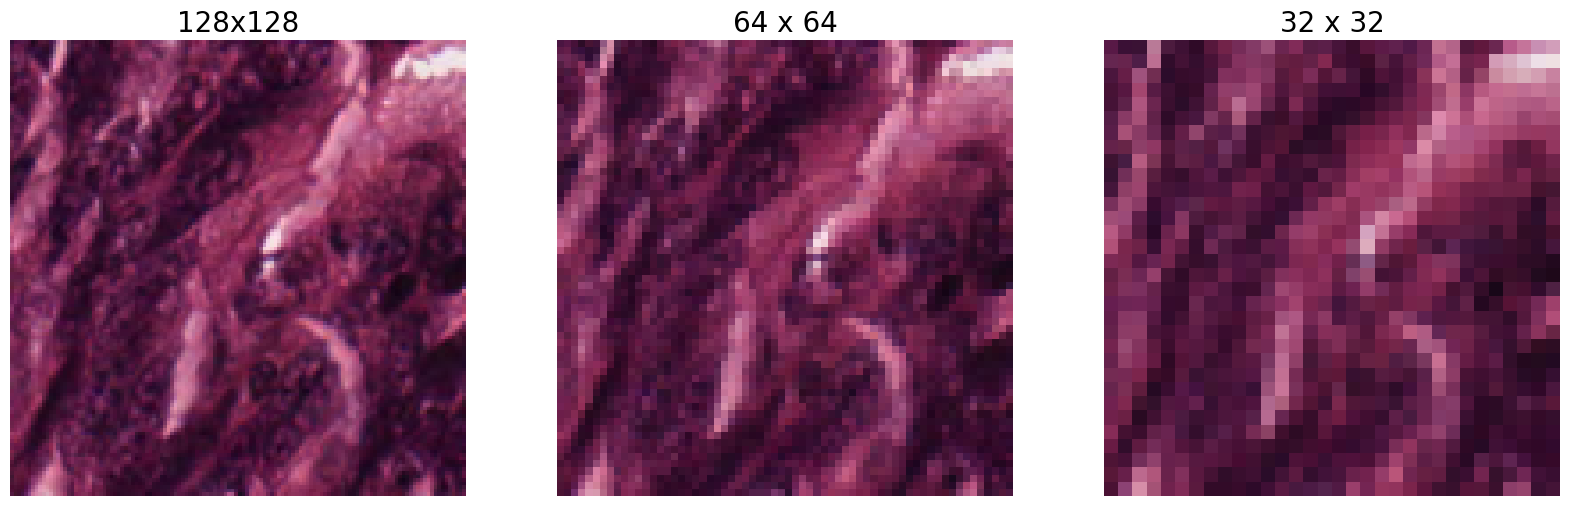

In [131]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(a128)
plt.title('128x128', fontsize = 20)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(a064)
plt.title('64 x 64', fontsize = 20)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(a032)
plt.title('32 x 32', fontsize = 20)
plt.axis('off')

### Optimizer

In [132]:
g_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
d0optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
d1optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
d2optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)

# Training for each batch

In [133]:
@tf.function
def train_on_batch (b_w_image, tar_image) :
    
    with tf.GradientTape(persistent = True) as  g :
        
        '''
        Image Tensors
        '''
        gen_image = gen0(b_w_image, training=True)
        
        # 128x128
        dis_tar_output_128 = dis0([b_w_image, tar_image], training = True)
        dis_gen_output_128 = dis0([b_w_image, gen_image], training = True)
        
        
        tar_image_128 = tar_image
        gen_image_128 = gen_image
        
        tar_image = tf.image.resize(tar_image, [64,64])
        b_w_image = tf.image.resize(b_w_image, [64,64])
        gen_image = tf.image.resize(gen_image, [64,64])
        
        # 064x064
        dis_tar_output_064 = dis1([b_w_image, tar_image], training = True)
        dis_gen_output_064 = dis1([b_w_image, gen_image], training = True)
        
        tar_image_064 = tar_image
        gen_image_064 = gen_image
        
        tar_image = tf.image.resize(tar_image, [32,32])
        b_w_image = tf.image.resize(b_w_image, [32,32])
        gen_image = tf.image.resize(gen_image, [32,32])
        
        # 032x032
        dis_tar_output_032 = dis2([b_w_image, tar_image], training = True)
        dis_gen_output_032 = dis2([b_w_image, gen_image], training = True)
        
        tar_image_032 = tar_image
        gen_image_032 = gen_image
        
        '''
        LOSS
        '''
        
        # 128x128
        g_loss_128, _, _ = gen_loss(dis_gen_output_128, tar_image_128, gen_image_128)
        d_loss_128 = dis_loss(dis_gen_output_128, dis_tar_output_128)
        
        # 064x064
        g_loss_064, _, _ = gen_loss(dis_gen_output_064, tar_image_064, gen_image_064)
        d_loss_064 = dis_loss(dis_gen_output_064, dis_tar_output_064)
        
        # 032x032
        g_loss_032, _, _ = gen_loss(dis_gen_output_032, tar_image_032, gen_image_032)
        d_loss_032 = dis_loss(dis_gen_output_032, dis_tar_output_032)
        
        
        g_total_loss = g_loss_128 + g_loss_064 + g_loss_032
        d_total_loss = d_loss_128 + d_loss_064 + d_loss_032
    
    # compute gradients
    g_gradients = g.gradient(g_total_loss, gen0.trainable_variables) # generatorLoss
    
    d0gradients = g.gradient(d_loss_128, dis0.trainable_variables)   # dis loss 128
    d1gradients = g.gradient(d_loss_064, dis1.trainable_variables)   # dis loss 064
    d2gradients = g.gradient(d_loss_032, dis2.trainable_variables)   # dis loss 032
    
    
    # apply gradient descent
    g_optimizer.apply_gradients(zip(g_gradients, gen0.trainable_variables))
    
    d0optimizer.apply_gradients(zip(d0gradients, dis0.trainable_variables))
    d1optimizer.apply_gradients(zip(d1gradients, dis1.trainable_variables))
    d2optimizer.apply_gradients(zip(d2gradients, dis2.trainable_variables))

# fit() method and model training

#### Note
<div style = "text-align: justify">The models have parameter <b>training = True</b> so that the batch statistics are calculated (eg. mean and variance) for the test dataset, and not the statistics from training dataset (in case you put <b>training = False</b>).</div>

Epoch 0 out of 50
#

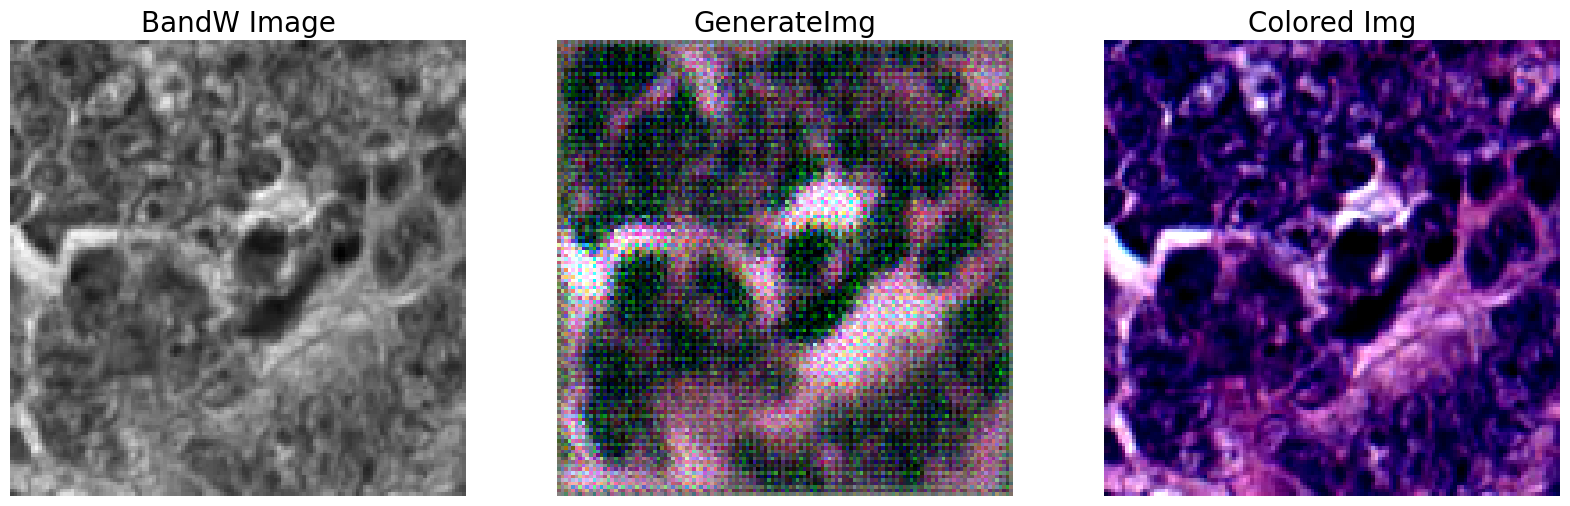

Epoch 1 out of 50
#Epoch 2 out of 50
#Epoch 3 out of 50
#

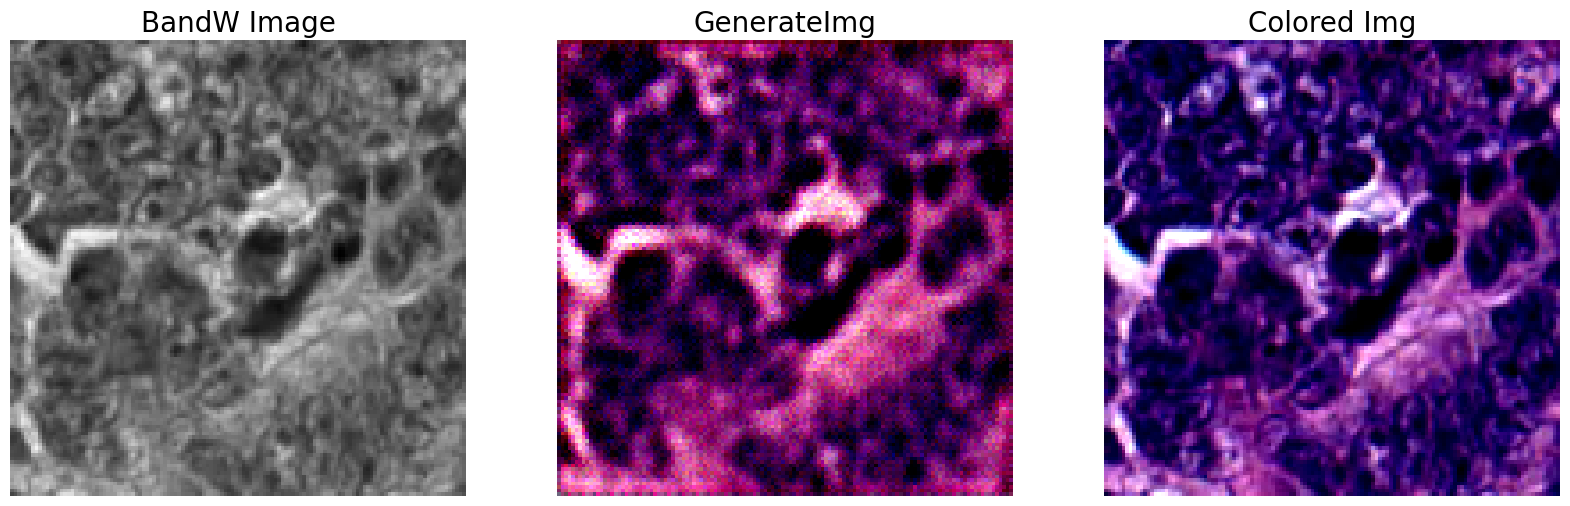

Epoch 4 out of 50
#Epoch 5 out of 50
#Epoch 6 out of 50
#

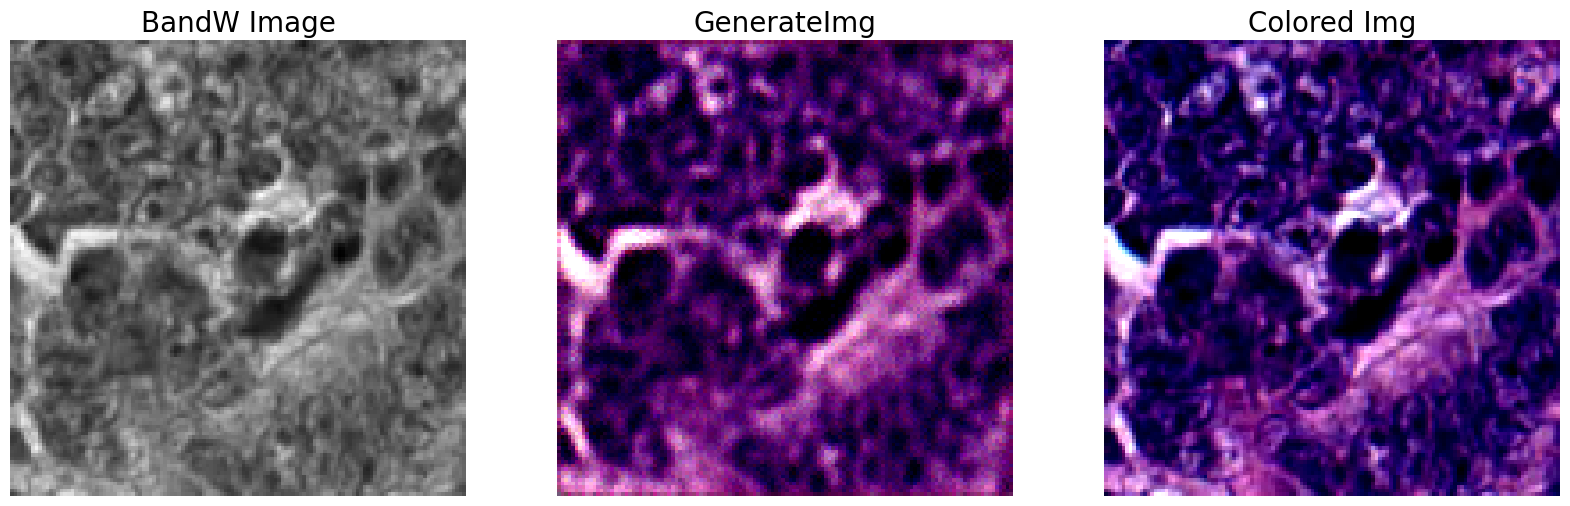

Epoch 7 out of 50
#Epoch 8 out of 50
#Epoch 9 out of 50
#

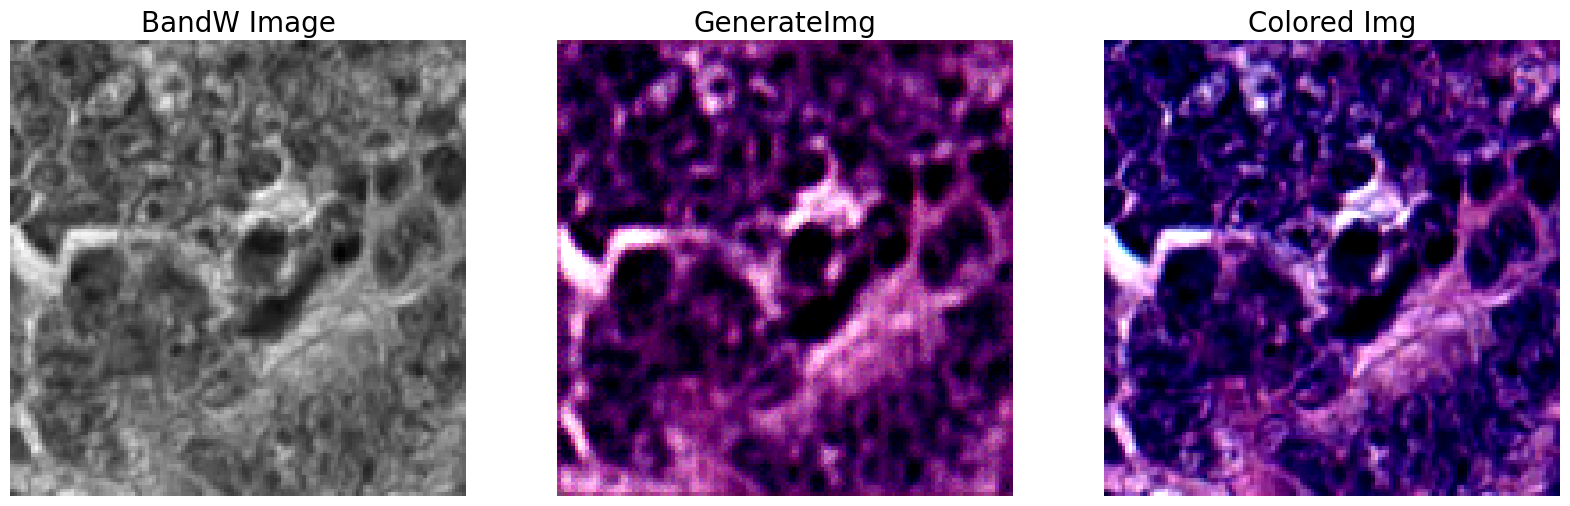

Epoch 10 out of 50
#Epoch 11 out of 50
#Epoch 12 out of 50
#

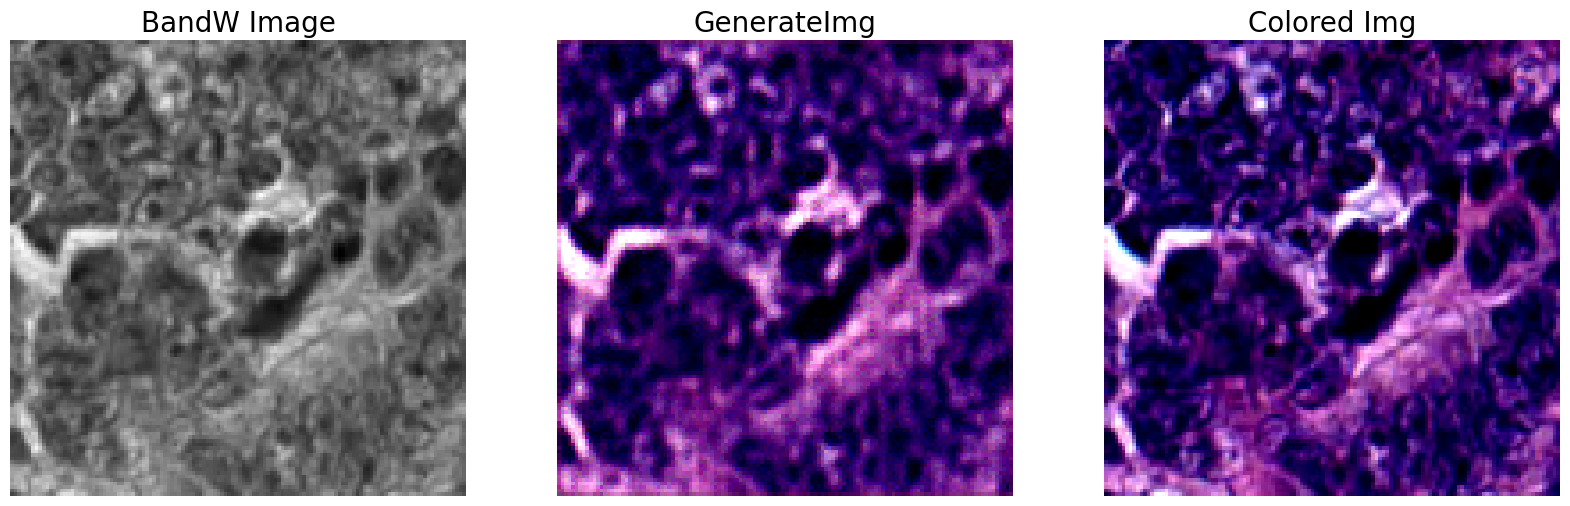

Epoch 13 out of 50
#Epoch 14 out of 50
#Epoch 15 out of 50
#

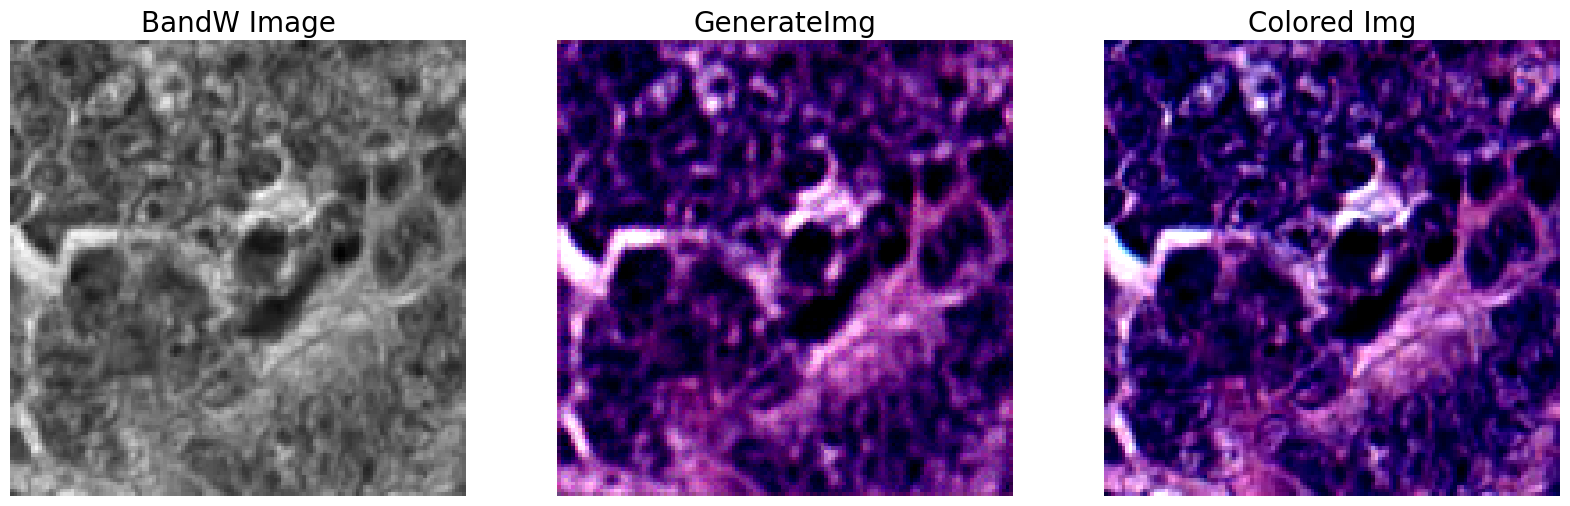

Epoch 16 out of 50
#Epoch 17 out of 50
#Epoch 18 out of 50
#

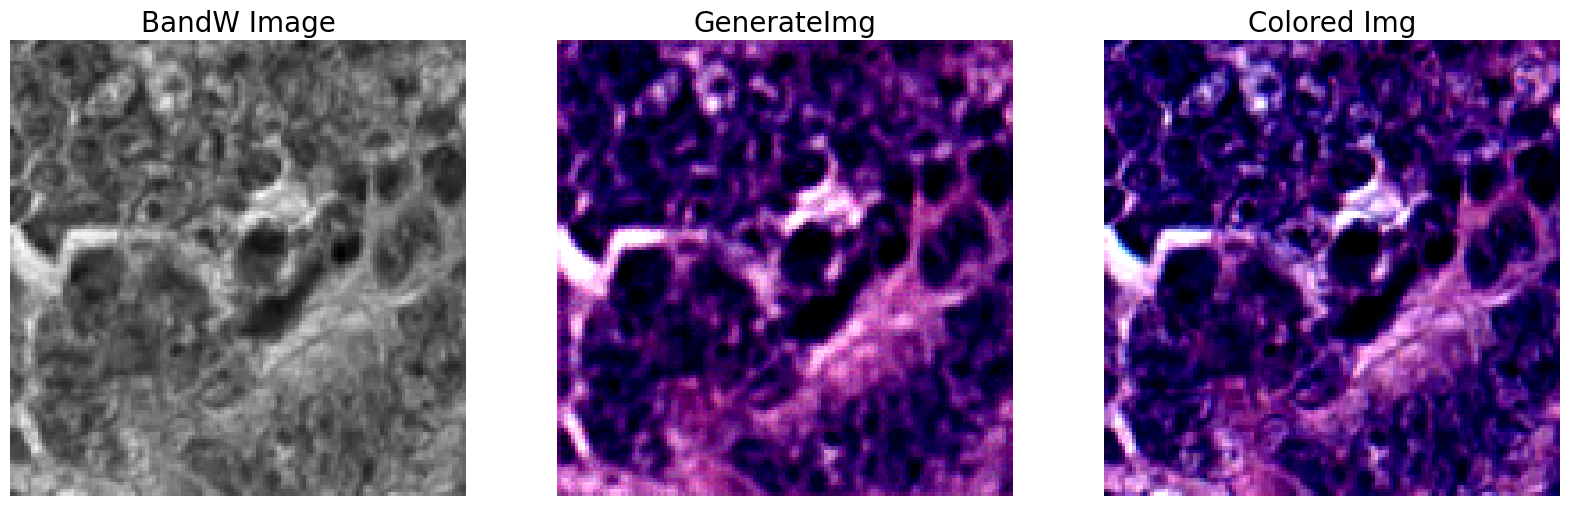

Epoch 19 out of 50
#Epoch 20 out of 50
#Epoch 21 out of 50
#

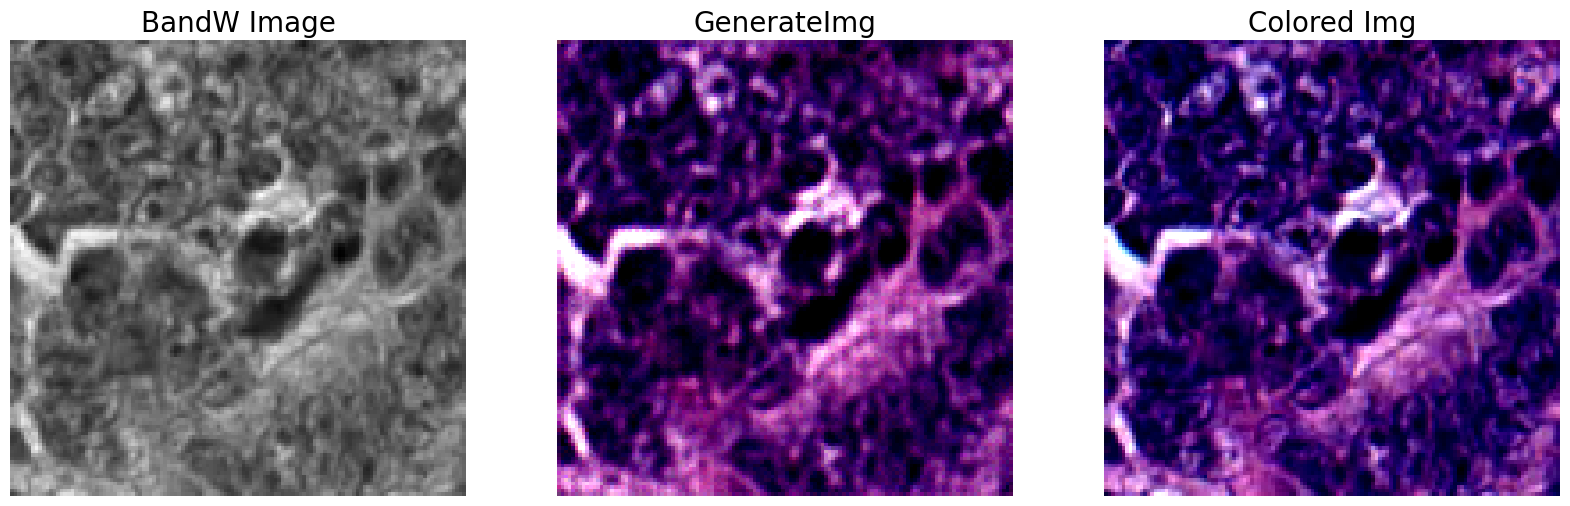

Epoch 22 out of 50
#Epoch 23 out of 50
#Epoch 24 out of 50
#

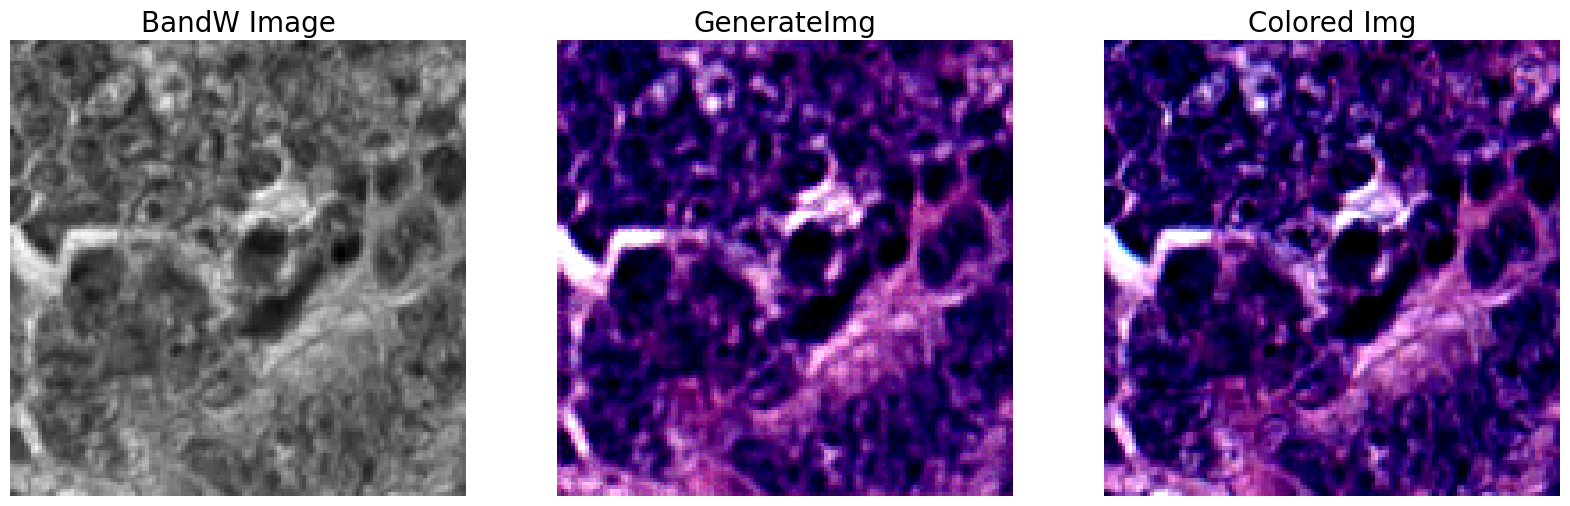

Epoch 25 out of 50
#Epoch 26 out of 50
#Epoch 27 out of 50
#

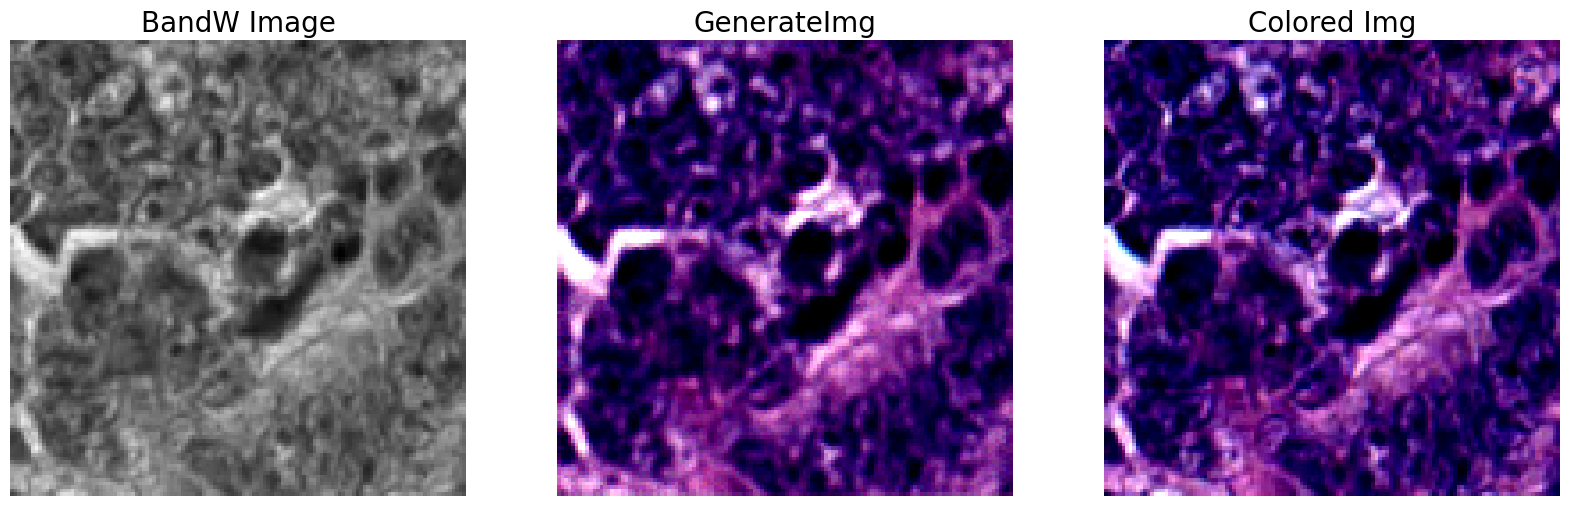

Epoch 28 out of 50
#Epoch 29 out of 50
#Epoch 30 out of 50
#

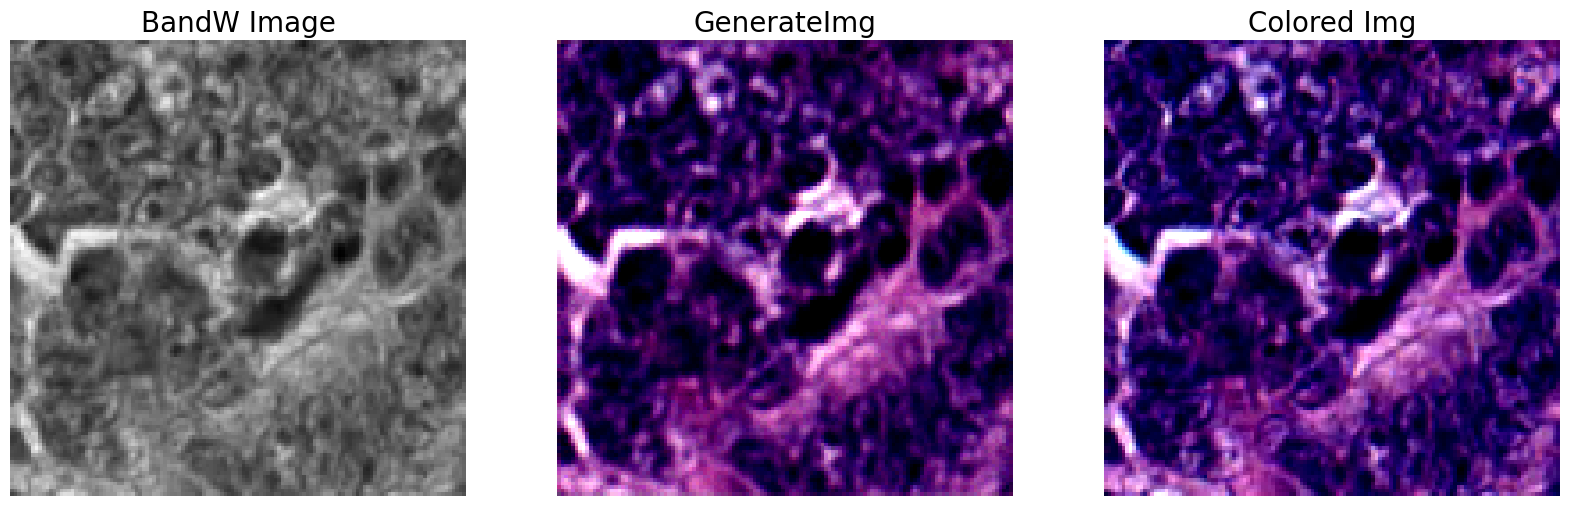

Epoch 31 out of 50
#Epoch 32 out of 50
#Epoch 33 out of 50
#

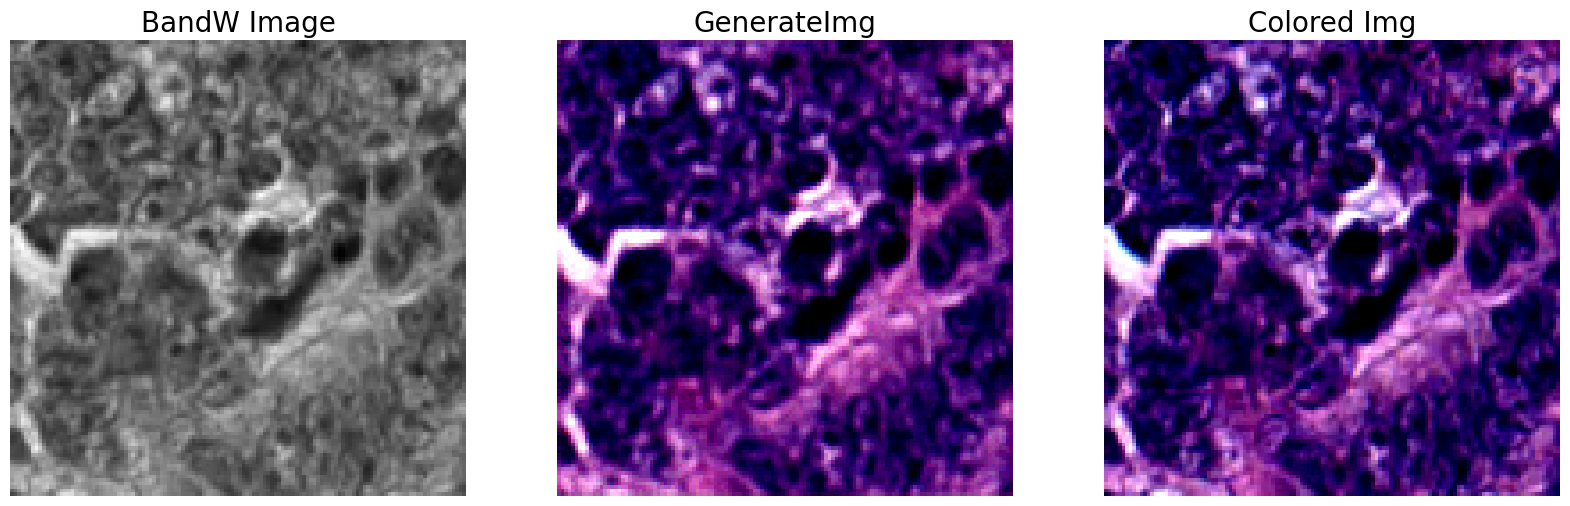

Epoch 34 out of 50
#Epoch 35 out of 50
#Epoch 36 out of 50
#

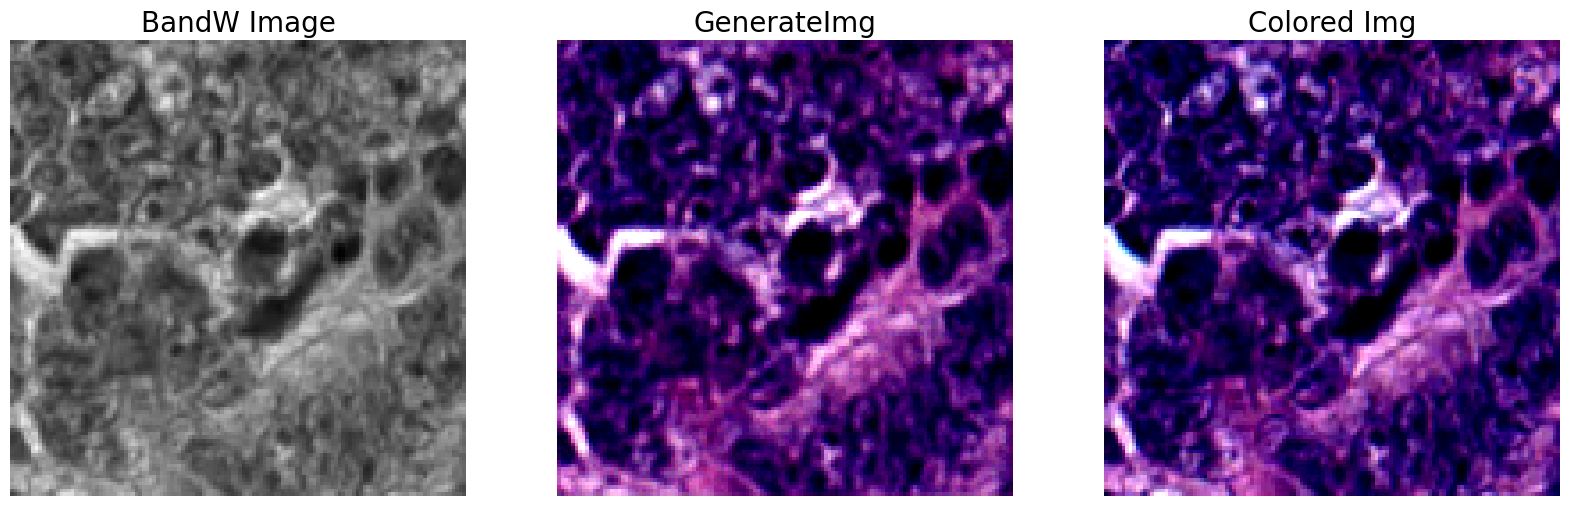

Epoch 37 out of 50
#Epoch 38 out of 50
#Epoch 39 out of 50
#

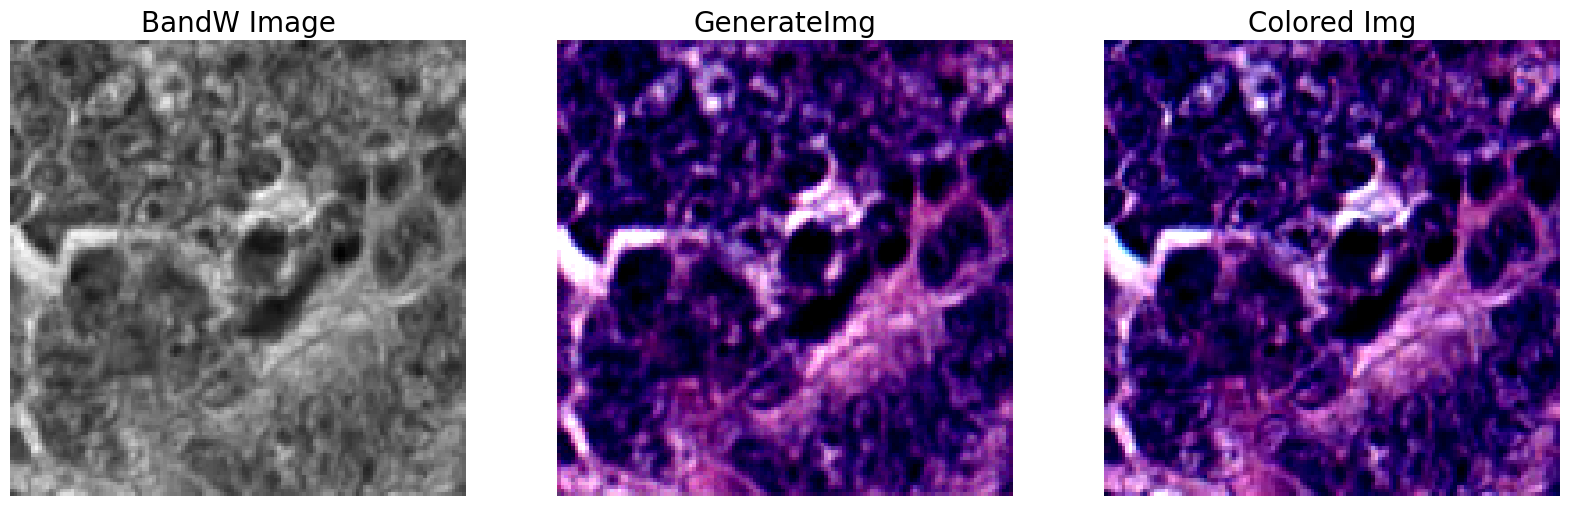

Epoch 40 out of 50
#Epoch 41 out of 50
#Epoch 42 out of 50
#

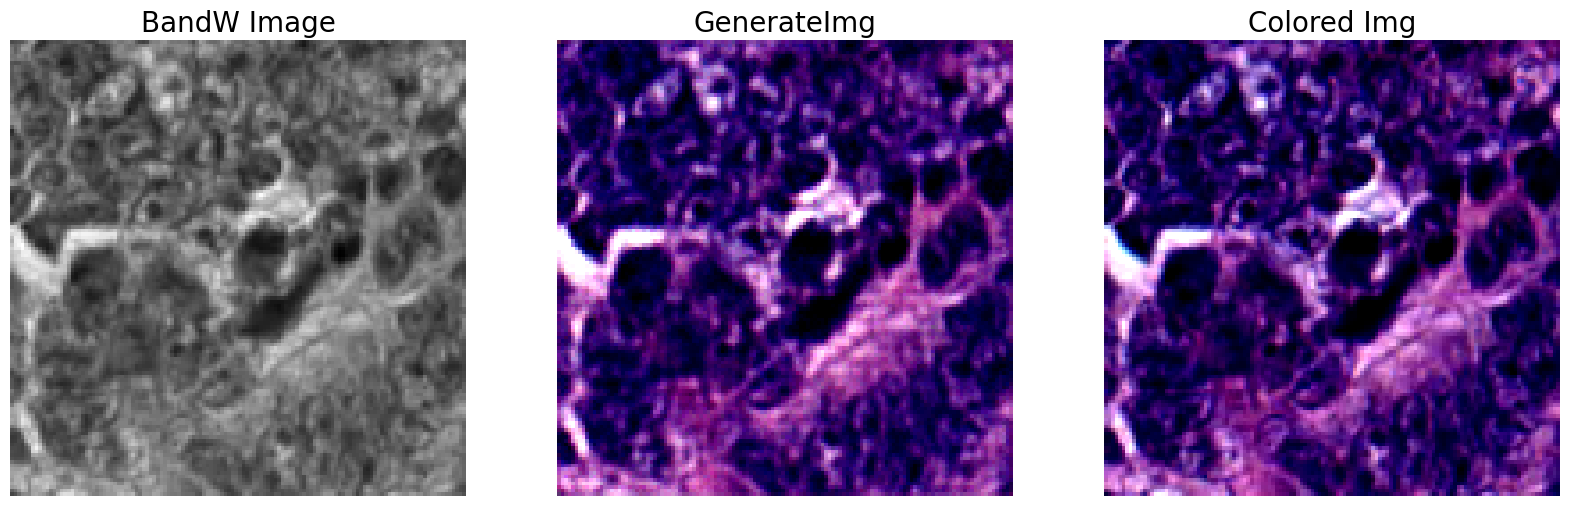

Epoch 43 out of 50
#Epoch 44 out of 50
#Epoch 45 out of 50
#

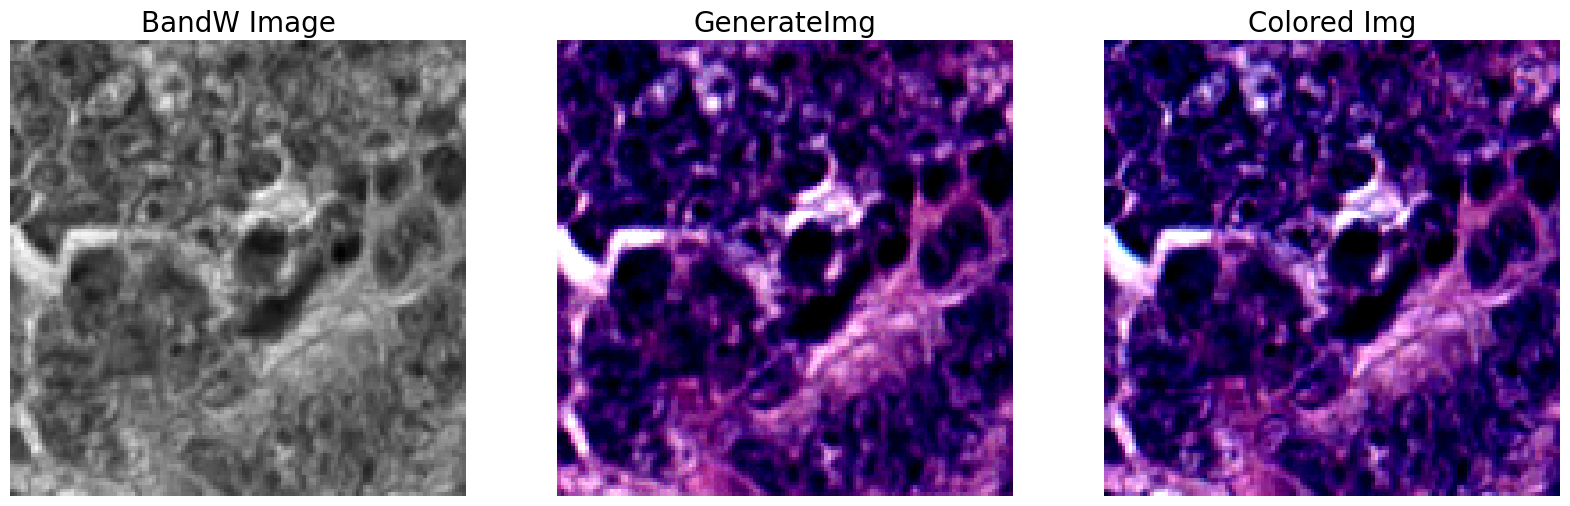

Epoch 46 out of 50
#Epoch 47 out of 50
#Epoch 48 out of 50
#

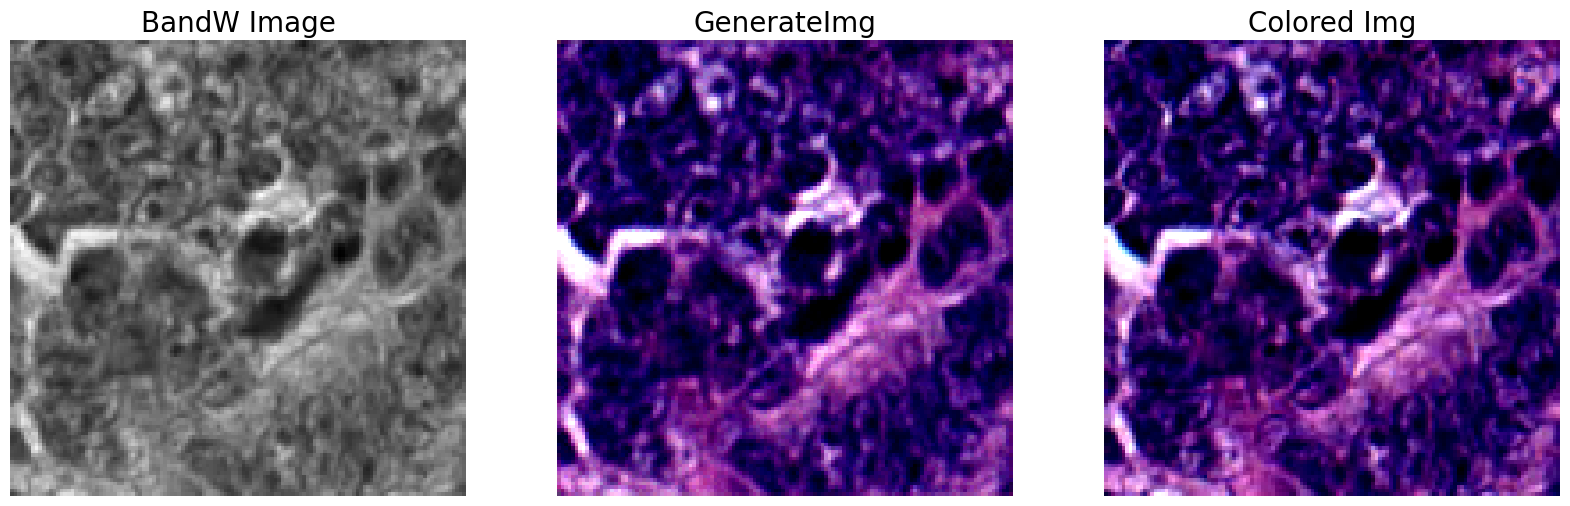

Epoch 49 out of 50
#

In [134]:
import matplotlib.colors as colors
def fig (b_w_image, gen_image, tar_image) :
    
    plt.figure(figsize = (20, 20))
    
    plt.subplot(1,3,1)
    #plt.imshow(np.array(b_w_image[0],np.int32))
    plt.imshow(b_w_image[0,:,:,:1]+1.0/2.0, cmap='gray')
    plt.title('BandW Image',fontsize = 20)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    #rescaled_arr = (np.array(gen_image[0]) - np.array(gen_image[0]).min()) / ((np.array(gen_image[0]).max() - np.array(gen_image[0]).min())*0.1)
    ##rescaled_arr = (np.array(gen_image[0]) - np.array(gen_image[0]).min()) / (np.array(gen_image[0]).max() - np.array(gen_image[0]).min())
    #plt.imshow(rescaled_arr)
    plt.imshow(gen_image[0]+1.0/2.0)
    plt.title('GenerateImg',fontsize = 20)
    plt.axis('off')

    #r = np.ptp(gen_image[0],axis=1)
    #print(r)
    plt.subplot(1,3,3)
    #plt.imshow(np.array(tar_image[0],np.int32))
    plt.imshow(tar_image[0]+1.0/2.0)
    plt.title('Colored Img',fontsize = 20)
    plt.axis('off')
    
    plt.show()

def fit (EPOCHS = 200) :
    
    for epoch in range(EPOCHS) :
        
        print(f'Epoch {epoch} out of {EPOCHS}')
        
        for n, (b_w_image, tar_image) in train_dataset.enumerate() :
            if n ==  265 :
                print('#....End')
            if n%20 == 0 :
                print('#',end='')
            train_on_batch(b_w_image, tar_image)
        
        if epoch%3  == 0 :
            global_gen_image = gen0(global_b_w_image,training = True)
            fig(global_b_w_image, global_gen_image, global_tar_image)
            
for global_b_w_image, global_tar_image in train_dataset.take(1) :
    pass
fit(EPOCHS = 50)

# Model Prediction

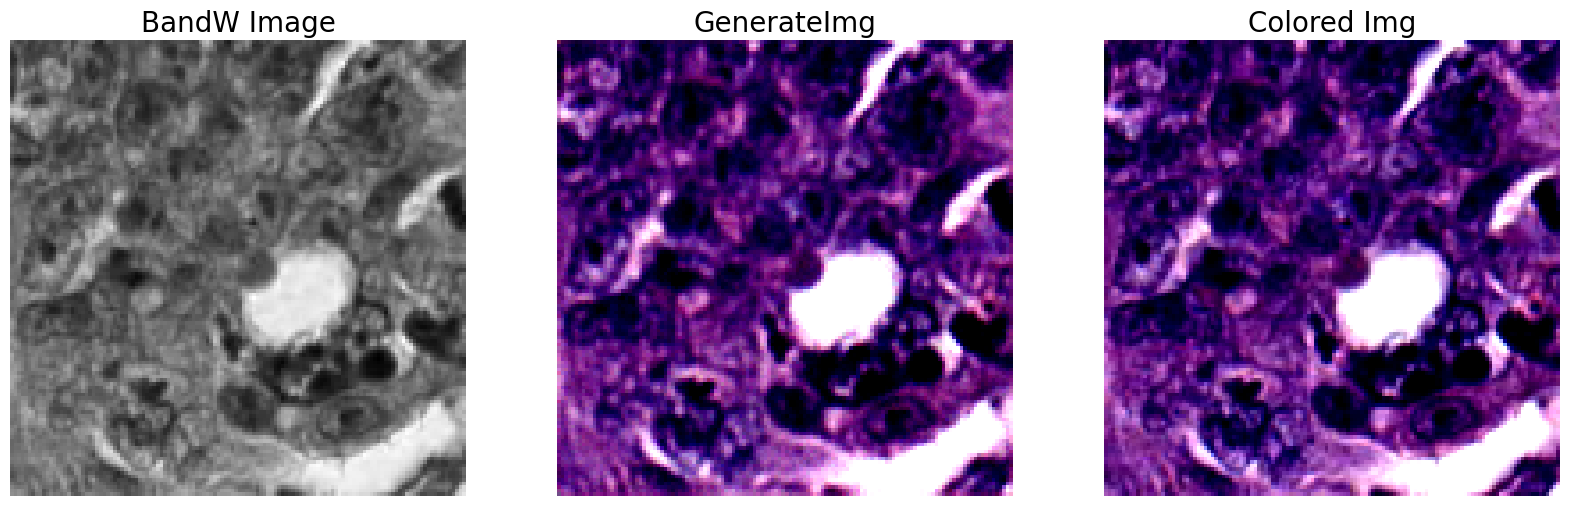

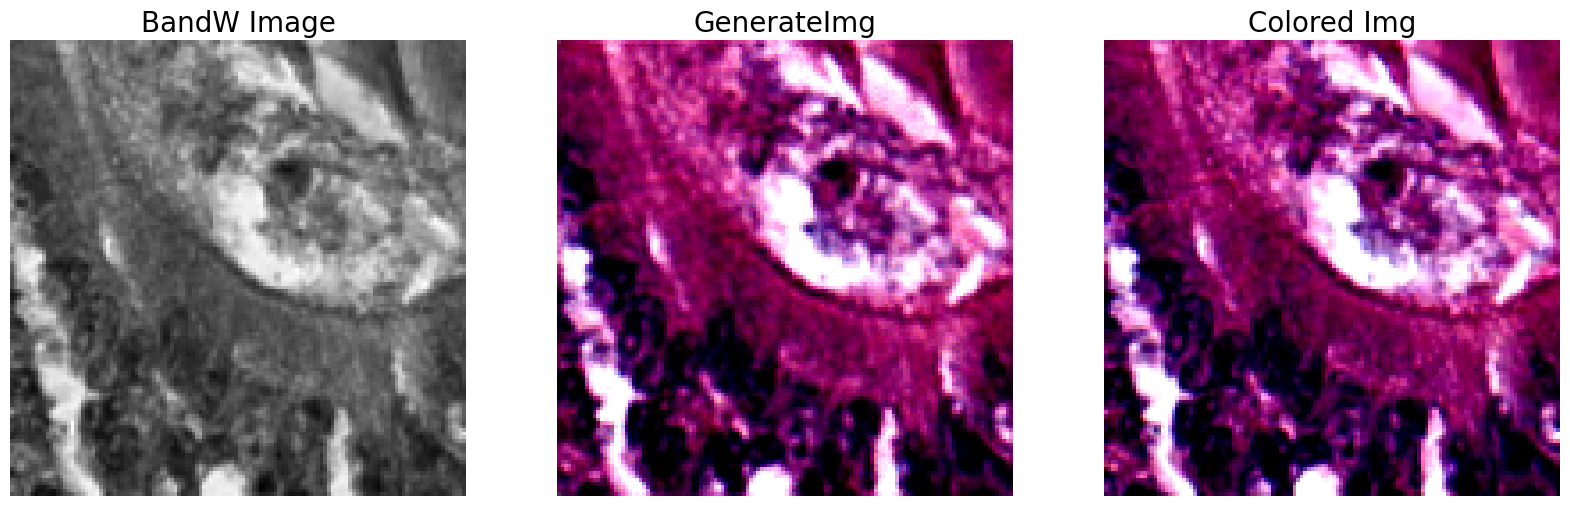

In [136]:
for b_w_image,tar_image in valid_dataset.take(20) :
    gen_image = gen0(b_w_image , training = True)
    fig(b_w_image, gen_image, tar_image)

### All models are saved

In [137]:
gen0.save('./gen0.h5')
dis0.save('./dis0.h5')
dis1.save('./dis1.h5')
dis2.save('./dis2.h5')